In [36]:
# !pip install tensorflow

In [37]:
# !pip install tensorflow-addons

In [38]:
# !pip install imageio

In [39]:
# !pip install librosa

In [40]:
# !pip install Ipython

In [41]:
# !pip install soundfile

In [42]:
# !pip install git+https://github.com/tensorflow/docs

In [43]:
import librosa

import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import clear_output

from tqdm.notebook import tqdm
import soundfile as sf
import tensorflow_docs.vis.embed as embed

import glob
from glob import glob
import imageio
import time

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [44]:
seed=111
tf.compat.v1.set_random_seed(seed)

session_config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_config)

tf.compat.v1.keras.backend.set_session(session)

In [45]:
""" Run only the first time to create the training and testing data """

# # Seperating the training and testing data
# # Dataset already contains an 75-25 split of training and testing (check the csv file for details)

# # Read the CSV file
# df1 = pd.read_csv('/Users/vamsi/Desktop/Learning/Autoencoder anomaly detection/data-warblr/warblrb10k_public_metadata.csv')
# df2 = pd.read_csv('/Users/vamsi/Desktop/Learning/Autoencoder anomaly detection/data-freefield/ff1010bird_metadata.csv')

# # Create lists for train and test datasets
# train_files = [] # Contains paths of all files needed for training
# test_files = []  # Contains paths of all files needed for testing

# # Iterate over the DataFrame 1 - warblr
# for index, row in tqdm(df1.iterrows()):
#     itemid = row['itemid']
#     hasbird = row['hasbird']
    
#     # Define the path of the audio file for training data
#     train_file_path = os.path.join('/Users/vamsi/Desktop/Learning/Autoencoder anomaly detection/data-warblr/wav', f'{itemid}.wav')  # replace .wav with your audio file extension
    
#     # If hasbird is 1, add the file to the train list
#     if hasbird == 1:
#         train_files.append(train_file_path)

# # Iterate over the DataFrame 2 - Freefield
# for index, row in tqdm(df2.iterrows()):
#     itemid = row['itemid']
#     hasbird = row['hasbird']
    
#     # Define the path of the audio file for training data
#     train_file_path = os.path.join('/Users/vamsi/Desktop/Learning/Autoencoder anomaly detection/data-freefield/wav', f'{itemid}.wav')  # replace .wav with your audio file extension
    
#     # If hasbird is 1, add the file to the train list
#     if hasbird == 1:
#         train_files.append(train_file_path)

# # Add all files in the chernobyl dataset to the test list
# test_file_path = '/Users/vamsi/Desktop/Learning/Autoencoder anomaly detection/data-chernobyl/wav'
# test_files = [os.path.join(test_file_path, f) for f in os.listdir(test_file_path) if f.endswith('.wav')]

# print(len(train_files))
# print(len(test_files))


' Run only the first time to create the training and testing data '

In [46]:
""" Run only the first time to pre-process the training and testing data """

# # Pre-processing for maintaing same features for all audio samples

# def process_audio(file_path, desired_length=10, sample_rate=44100):
#     # Load audio file with desired sample rate
#     audio, sr = librosa.load(file_path, sr=sample_rate)

#     # If audio is too short, pad with zeros at the end
#     if len(audio) < desired_length * sample_rate:
#         audio = np.pad(audio, (0, desired_length * sample_rate - len(audio)))

#     # If audio is too long, truncate it at the end
#     elif len(audio) > desired_length * sample_rate:
#         audio = audio[:desired_length * sample_rate]

#     return audio, sr

# # Process all files in your train dataset and save to new path
# for i in tqdm(range(len(train_files))):
#     audio, sr = process_audio(train_files[i])
#     new_path = os.path.join('/Users/vamsi/Desktop/Learning/Autoencoder anomaly detection/train', os.path.basename(train_files[i]))
#     sf.write(new_path, audio, sr)

# # Process all files in your test dataset and save to new path
# for i in tqdm(range(len(test_files))):
#     audio, sr = process_audio(test_files[i])
#     new_path = os.path.join('/Users/vamsi/Desktop/Learning/Autoencoder anomaly detection/test', os.path.basename(test_files[i]))
#     sf.write(new_path, audio, sr)



' Run only the first time to pre-process the training and testing data '

In [47]:
# train and test file paths
train_file_path = '/Users/vamsi/Desktop/Learning/Autoencoder anomaly detection/train'
train_files = [os.path.join(train_file_path, f) for f in os.listdir(train_file_path) if f.endswith('.wav')]

test_file_path = '/Users/vamsi/Desktop/Learning/Autoencoder anomaly detection/test'
test_files = [os.path.join(test_file_path, f) for f in os.listdir(test_file_path) if f.endswith('.wav')]

In [48]:
# Training and validation parameters

train_size = 7980
BATCH_SIZE = 15
test_size = 8620
epochs = 20

latent_dim = 2 # Dimensions of latent space for visualisation
num_examples_to_generate = 10 # Example generated outputs

In [49]:
# Function to load files

def load(file):
    data, sampling_rate = librosa.load(file, sr=None, offset=0.0, duration=10)
    data = data.reshape(1,-1) # reshapes to original sampling rate of 441000, reduce accordingly
    #print(data.shape)
    return data

map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

In [50]:
# Sampling original music

sample = train_files[1]
sample, sampling_rate = librosa.load(sample, sr=None, offset=0.0, duration=10)
ipd.Audio(sample, rate=sampling_rate)

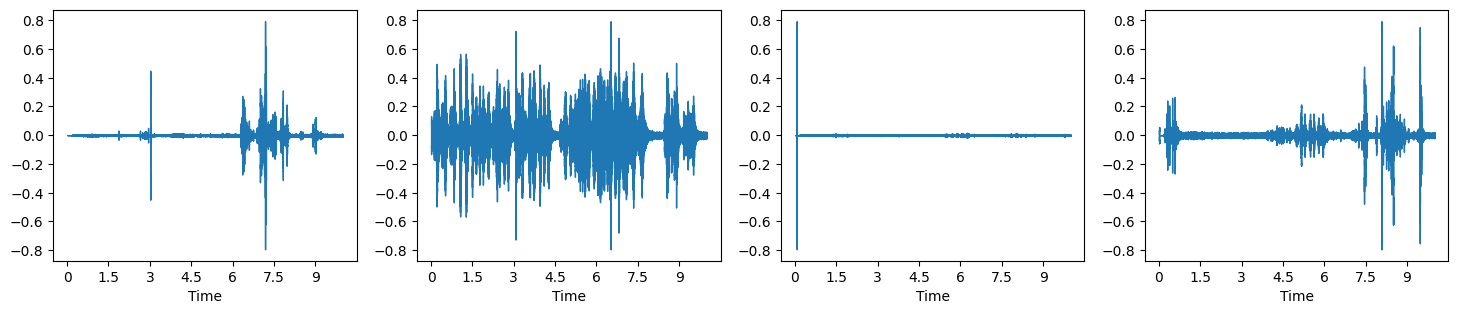

In [51]:
# Displaying the amplitude envelopes of examples from training data

plt.figure(figsize=(18, 15))
for i in range(4):
    plt.subplot(4, 4, i+1)
    j = load(train_files[i])
    librosa.display.waveshow(j[0], sr=sampling_rate)

In [52]:
# Creating tensors from training and testing data

train_dataset = (tf.data.Dataset.from_tensor_slices((train_files)).map(map_data, num_parallel_calls=AUTOTUNE).shuffle(3).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices((test_files)).map(map_data, num_parallel_calls=AUTOTUNE).shuffle(3).batch(BATCH_SIZE))

In [53]:
# Building the network

class ResNet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters, type = 'encode', name=None):
        super(ResNet1DBlock, self).__init__(name=name)

        if type == 'encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2, padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1, padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        
        elif type == 'decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1, padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1, padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        
        else:
            raise ValueError("Type must be either 'encode' or 'decode'")
    
    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)
    
"""
The slope of the LeakyReLU activation function is a hyperparameter that you can tune based on your specific use case. There isnt a one-size-fits-all value that works best for all types of data and models.

However, a common starting point is to use a small value for the slope, this allows the function to pass a small gradient when the unit is not active, which can help mitigate the “dying ReLU” problem where neurons become inactive and only output 0.

You could also consider using techniques like grid search or random search to systematically explore different hyperparameters, or use libraries like Keras Tuner or Hyperopt that are designed for hyperparameter optimization.
"""

'\nThe slope of the LeakyReLU activation function is a hyperparameter that you can tune based on your specific use case. There isnt a one-size-fits-all value that works best for all types of data and models.\n\nHowever, a common starting point is to use a small value for the slope, this allows the function to pass a small gradient when the unit is not active, which can help mitigate the “dying ReLU” problem where neurons become inactive and only output 0.\n\nYou could also consider using techniques like grid search or random search to systematically explore different hyperparameters, or use libraries like Keras Tuner or Hyperopt that are designed for hyperparameter optimization.\n'

In [54]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1,441000)),
                layers.Conv1D(64,1,2),
                ResNet1DBlock(64,1),
                layers.Conv1D(128,1,2),
                ResNet1DBlock(128,1),
                layers.Conv1D(128,1,2),
                ResNet1DBlock(128,1),
                layers.Conv1D(256,1,2),
                ResNet1DBlock(256,1),
                # No activation
                layers.Flatten(),
                layers.Dense(latent_dim+latent_dim)

            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                layers.Reshape(target_shape=(1,latent_dim)),
                ResNet1DBlock(512,1,'decode'),
                layers.Conv1DTranspose(512,1,1),
                ResNet1DBlock(256,1,'decode'),
                layers.Conv1DTranspose(256,1,1),
                ResNet1DBlock(128,1,'decode'),
                layers.Conv1DTranspose(128,1,1),
                ResNet1DBlock(64,1,'decode'),
                layers.Conv1DTranspose(64,1,1),
                # No activation
                layers.Conv1DTranspose(441000,1,1),
            ]
        )
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [55]:
optimizer = tf.keras.optimizers.Adam(0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [56]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0*np.pi)
    return tf.reduce_sum(-0.5*((sample - mean)**2.0*tf.exp(-logvar)+logvar+log2pi),axis=raxis)

In [57]:
@tf.function
def compute_loss(model, x):
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0.0, 0.0)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [58]:
@tf.function
def train_step(model, x, optimizer):
    
    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [59]:
# keeping the random vector constant for generation (prediction) as it will be easier to see the improvement.
# only for visualisation of training
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [60]:
def generate_and_save_images(model, epoch, test_sample, save):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        librosa.display.waveshow(wave[0], sr=3000)

    # Create a new directory if it doesn't exist
    if not os.path.exists('training_outputs'):
        os.makedirs('training_outputs')
        print("training_outputs directory created")
    else:
        print("training_outputs directory exists")

    # Save the figure in the new directory
    plt.savefig('training_outputs/{}_{:04d}.png'.format(save, epoch))
    plt.show()

In [61]:
# Defining checkpoints to save model weights

if not os.path.exists('training_checkpoints_v1'):
    os.makedirs('training_checkpoints_v1')
    print("training_checkpoints_v1 directory created")
else:
    print("training_checkpoints_v1 directory exists")

checkpoint_dir = 'training_checkpoints_v1'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

training_checkpoints_v1 directory created


In [62]:
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

training_outputs directory created


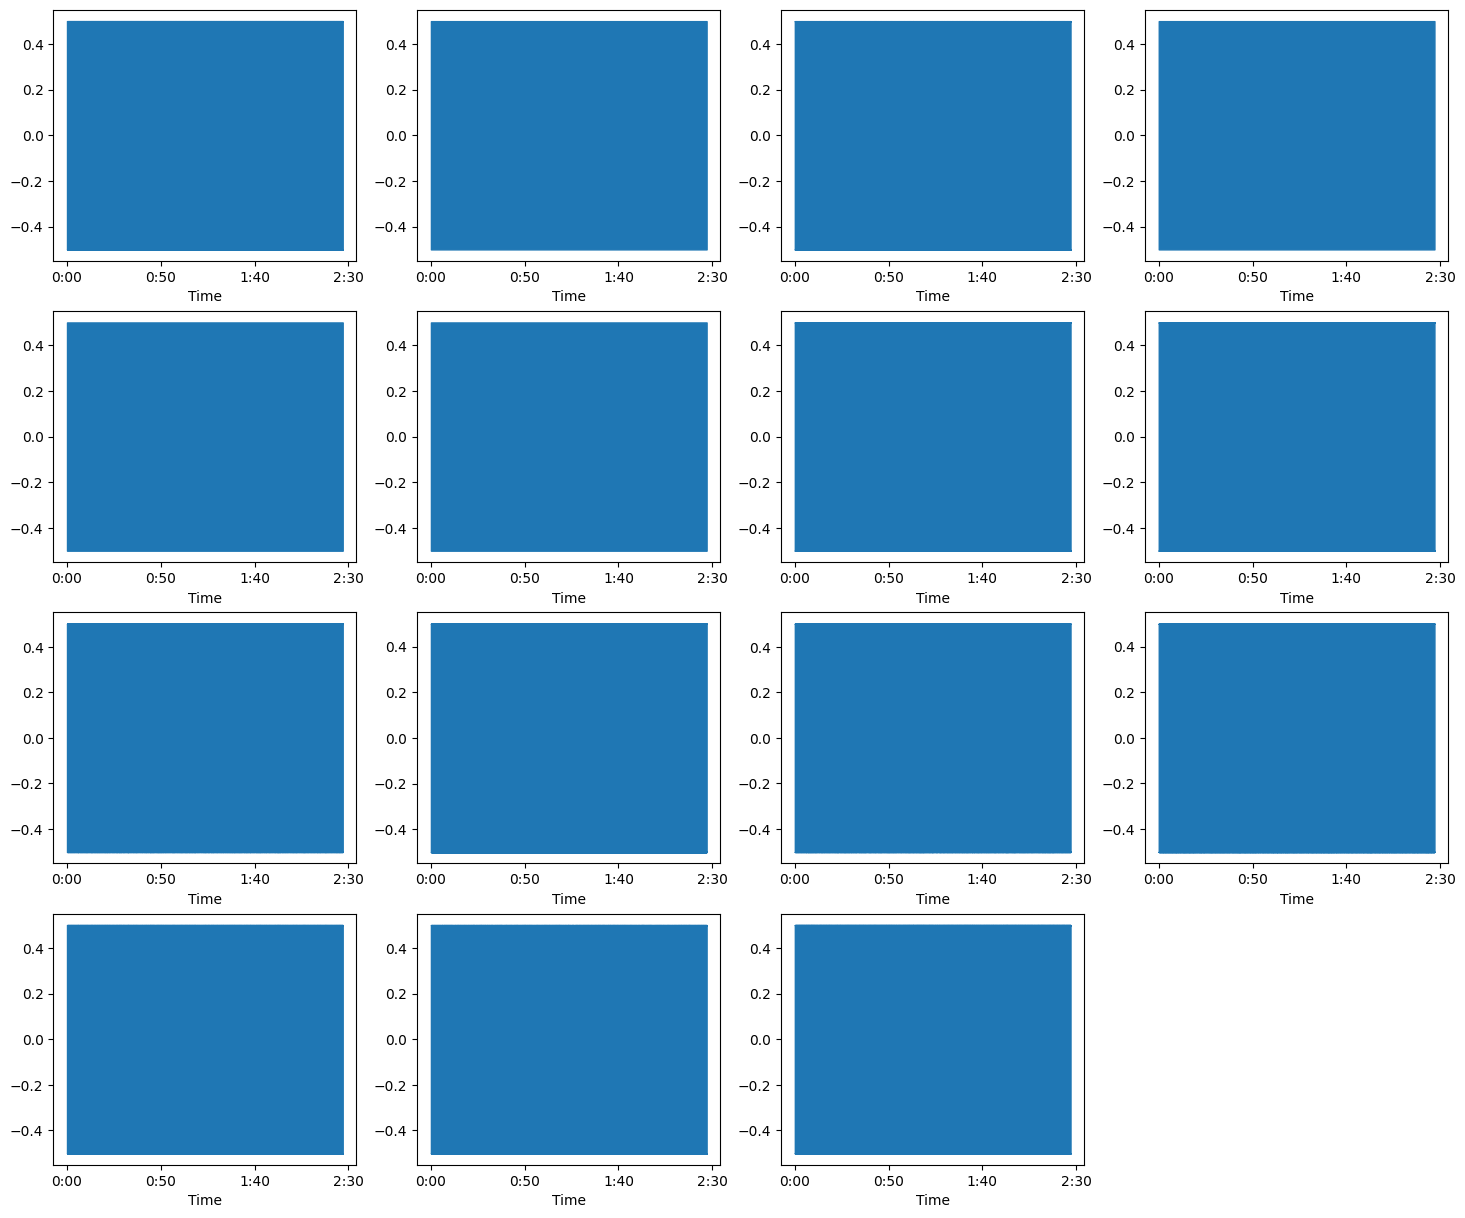

Epoch: 1


  0%|                                         | 0/532 [00:00<?, ?it/s]

In [ ]:
generate_and_save_images(model, 0, test_sample, 'init')

def train(train_dataset, test_dataset, model, save):
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        print(f"Epoch: {epoch}")
        with tqdm(total=len(train_dataset), ncols=70) as pbar:
            for train_x in train_dataset:
                train_x = np.asarray(train_x)[0]
                train_step(model, train_x, optimizer)
                pbar.update(1)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            test_x = np.asarray(test_x)[0]
            loss(compute_loss(model, test_x))
        display.clear_output(wait=False)
        elbo = -loss.result()
        print('Test set ELBO: {}, time elapse for current epoch: {}'.format(elbo, end_time - start_time))
        generate_and_save_images(model, epoch, test_sample, save)
        
        # Saving the model every few epochs
        if (epoch % 10) == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

train(train_dataset, test_dataset, model, 'init')

In [ ]:
# Visualise the training as a GIF 
# See the changes that the audio signal went through while the VAE learnt to build bird sounds from random noise

anim_file_1 = 'training_process.gif'

with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('training_outputs/jazz*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

embed.embed_file(anim_file_1)